# Identify specific populations and expand these masks using multiobject approach 

# This is a class that will suffer a lot of changes in the future 

We will use gamma delta cells, cells that are hard to identiify sometimes and CD8 T cells as conterpoint 
Differently from the single object, we will use contours CD8 and GD and expand these objects only to the part that is more close to that object than the other object. 

We will find these regions, expand to see the surroundings and check how this maps in cell segmentation

In [1]:
%load_ext autoreload

import os 
import sys
import time
import logging
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json

from natsort import natsorted
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from PIL import Image, ImageDraw
import json
import math
import matplotlib.patches as mpatches


sys.path.append(os.path.dirname(os.getcwd()))
from GRIDGEN.src import get_arrays as ga
from GRIDGEN.src import contours 
from GRIDGEN.src import masks
from GRIDGEN.src.mask_properties import GetMasksProperties

define looger -- important to save info of the runs 

In [2]:
# define the logger :  can be None, and is set to INFO
# Custom logger setup
logger = logging.getLogger('contour_logger')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

define files

In [3]:
tma1_path = '../../xenium_data/HLA/GD_TMA1_S3/fov_filtered'
tma2_path = '../../xenium_data/HLA/HLA_TMA2/fov_filtered'
files_tma1 = os.listdir(tma1_path)
files_tma2 = os.listdir(tma2_path)


to_exclude = ['TMA1_Selection15_filtered.csv', # tonsil
              'TMA1_Selection24_filtered.csv', # tonsl 
            'TMA1_Selection18_filtered.csv' , # normal
            'TMA2_Selection11_filtered.csv', # normal
             ]
              
# Adding the full path to each file
files_tma1 = [os.path.join(tma1_path, file) for file in files_tma1 if file not in to_exclude]
files_tma2 = [os.path.join(tma2_path, file) for file in files_tma2 if file not in to_exclude]

files = files_tma1 + files_tma2
print(len(files))

73


# 2. Define contours of GD and CD8 

This intends to, based on defined genes, find GD and CD8 objects.

We need to define: 

1. Parameters for GD contours
    * Genes to consider :
  
    * density
    * minimum area
    * kernel size
    
    this will define for an overlapping area with "kernel size" * "kernel_size" a minimum number of "density" genes of interest. The contiguous area of the contour will have at least "minimum area" 
 
2. You may also need to define extra parameters to filter out wrong contours   

In [4]:
# we will do for a single file 
file_csv = files[7]
print(file_csv)

df_total = pd.read_csv(file_csv)
df_total = df_total[['x_location', 'y_location', 'feature_name']]
df_total = df_total.rename(columns={'feature_name': 'target'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]
df_total['X'] = df_total['x_location'] - min(df_total['x_location'])
df_total['Y'] = df_total['y_location'] - min(df_total['y_location'])

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1

print(f'n genes: {n_genes}')
print(f'shape: {height}, {width}')
print(f'n hits {len(df_total)}')

# this makes the sparse df to an array with the spatial information 
target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_gd, array_subset_gd, target_indices_subset_gd = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                                target_list=['TRGC1','TRGC2','TRDC'],
                                                                               target_col='target')

df_subset_cd8, array_subset_cd8, target_indices_subset_cd8 = ga.get_subset_arrays(df_total, array_total,
                                                                                      target_dict_total,
                                                                                      target_list=['CD8A', 'TRBC1', 'TRBC2', 'TRAC'],
                                                                                      target_col='target')
                                                                               
df_subset_ab, array_subset_ab, target_indices_subset_ab = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                                target_list=['TRBC1', 'TRBC2', 'TRAC'],
                                                                                target_col='target')


df_subset_g, array_subset_g, target_indices_subset_g = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                            target_list=['TRGC1', 'TRGC2'],
                                                                            target_col='target')

df_subset_TRBC1_2_gene, array_subset_TRBC1_2_gene, target_indices_subset_TRBC1_2_gene = ga.get_subset_arrays(df_total, 
                                                                                    array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRBC1','TRBC2'],
                                                                                      target_col='target')

df_subset_d, array_subset_d, target_indices_subset_d = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                            target_list=['TRDC'],
                                                                            target_col='target') 


df_subset_TRAC_gene, array_subset_TRAC_gene, target_indices_subset_TRAC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRAC'],
                                                                                      target_col='target')

df_subset_cd8_gene, array_subset_cd8_gene, target_indices_subset_cd8_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['CD8A'],
                                                                                      target_col='target')

df_subset_cd4_gene, array_subset_cd4_gene, target_indices_subset_cd4_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['CD4'],
                                                                                      target_col='target')



../../xenium_data/HLA/GD_TMA1_S3/fov_filtered/TMA1_Selection25_filtered.csv
n genes: 480
shape: 1935, 1785
n hits 4210232


Contours GD

2024-11-08 19:52:05,904 - contour_logger - INFO - Excluding contour 1. Gene gd count 3.0 is not greater than gene ab count 3.0
2024-11-08 19:52:05,914 - contour_logger - INFO - Excluding contour 2. Gene gd count 5.0 is not greater than gene ab count 8.0
2024-11-08 19:52:05,925 - contour_logger - INFO - Excluding contour 3. Gene gd count 1.0 is not greater than gene ab count 1.0
2024-11-08 19:52:05,935 - contour_logger - INFO - Excluding contour 4. Gene gd count 4.0 is not greater than gene ab count 6.0
2024-11-08 19:52:05,965 - contour_logger - INFO - Excluding contour 7. Gene gd count 5.0 is not greater than gene ab count 10.0
2024-11-08 19:52:05,984 - contour_logger - INFO - Excluding contour 9. Gene gd count 4.0 is not greater than gene ab count 6.0
2024-11-08 19:52:05,995 - contour_logger - INFO - Excluding contour 10. Gene gd count 3.0 is not greater than gene ab count 10.0
2024-11-08 19:52:06,005 - contour_logger - INFO - Excluding contour 11. Gene gd count 3.0 is not greater tha

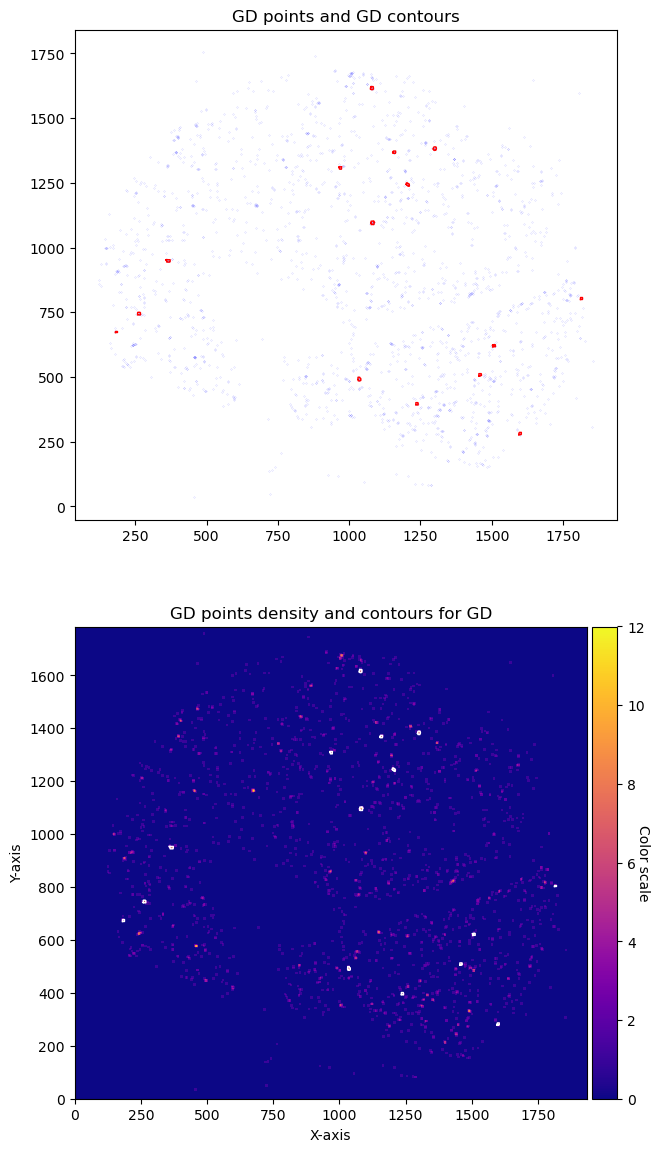

total contours found  15


In [5]:
### obtain contours GD
density_th_gd = 2
min_area_th_gd = 5  # 40
kernel_size_gd = 10 #90 #90



CGD = contours.GetContour(array_subset_gd, contour_name='GD', logger=logger)
CGD.get_conv_sum(kernel_size=kernel_size_gd, kernel_shape='square')  #
CGD.contours_from_sum(density_threshold=density_th_gd,
                      min_area_threshold=min_area_th_gd, directionality='higher')

#  AB < GD
CGD.filter_contours_by_gene_comparison(gene_array1 = array_subset_gd, gene_array2 = array_subset_ab,
                                       gene_name1 = "gd", gene_name2 = "ab") # gene 1 > gene2 --> valid contour 
# G>0 D>0
CGD.filter_contours_by_gene_threshold(gene_array = array_subset_d.squeeze(), threshold = 1, gene_name = 'TRDC')# >= 1
CGD.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_g, axis=-1), threshold = 1, gene_name = 'TRGC1_2')# >= 1


fig, axs = plt.subplots(2, 1, figsize=(7,14))

CGD.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                              c_points='blue', c_contours='red', ax=axs[0])
axs[0].set_title('GD points and GD contours')

CGD.plot_conv_sum(cmap='plasma', c_countour='white', path=None, ax=axs[1])
axs[1].set_title('GD points density and contours for GD')

plt.show()


print('total contours found ', len(CGD.contours))


contours CD8

2024-11-08 19:52:08,896 - contour_logger - INFO - Excluding contour 2. Gene CD8 count  0.0 is below threshold 1
2024-11-08 19:52:08,902 - contour_logger - INFO - Excluding contour 3. Gene CD8 count  0.0 is below threshold 1
2024-11-08 19:52:08,908 - contour_logger - INFO - Excluding contour 4. Gene CD8 count  0.0 is below threshold 1
2024-11-08 19:52:08,924 - contour_logger - INFO - Excluding contour 7. Gene CD8 count  0.0 is below threshold 1
2024-11-08 19:52:08,961 - contour_logger - INFO - Excluding contour 14. Gene CD8 count  0.0 is below threshold 1
2024-11-08 19:52:08,967 - contour_logger - INFO - Excluding contour 15. Gene CD8 count  0.0 is below threshold 1
2024-11-08 19:52:08,978 - contour_logger - INFO - Excluding contour 17. Gene CD8 count  0.0 is below threshold 1
2024-11-08 19:52:09,005 - contour_logger - INFO - Excluding contour 22. Gene CD8 count  0.0 is below threshold 1
2024-11-08 19:52:09,017 - contour_logger - INFO - Excluding contour 24. Gene CD8 count  0.0 is below

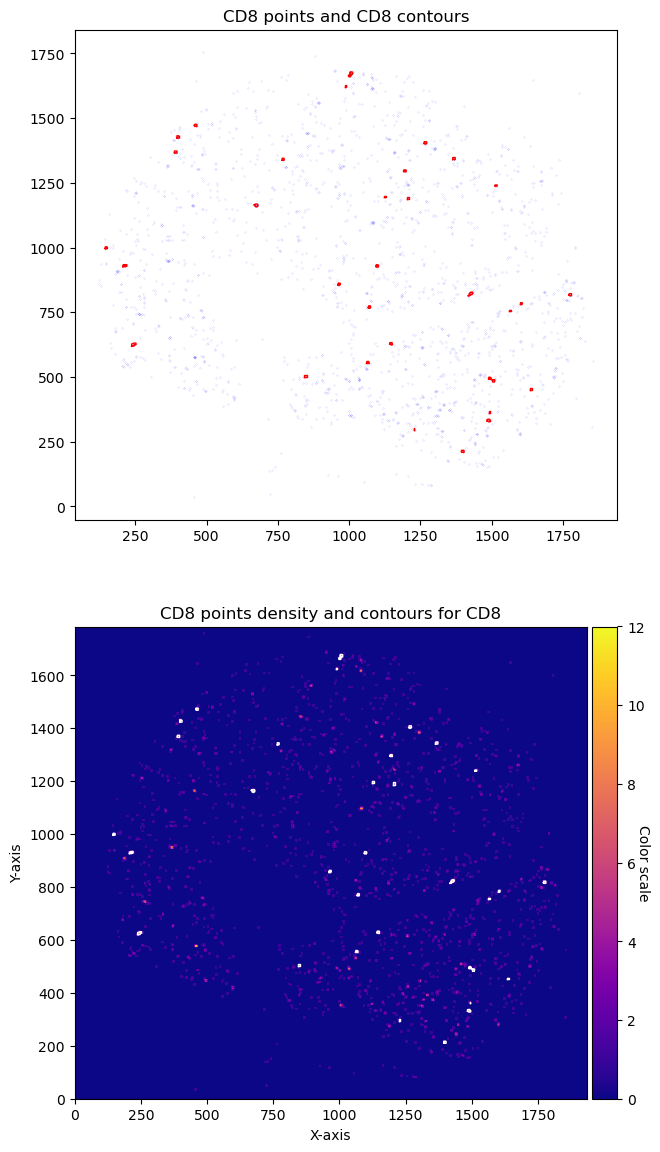

total contours found  33


In [6]:
### obtain contours 
density_th_cd8 = 3
min_area_th_cd8 = 5
kernel_size_cd8 = 10

CCD8 = contours.GetContour(array_subset_gd, contour_name='CD8a', logger=logger)
CCD8.get_conv_sum(kernel_size=kernel_size_cd8, kernel_shape='square')  
CCD8.contours_from_sum(density_threshold=density_th_cd8,
                      min_area_threshold=min_area_th_cd8, directionality='higher')

CCD8.filter_contours_by_gene_threshold(gene_array = array_subset_cd8_gene.squeeze(), threshold = 1, gene_name = 'CD8')# >= 1
CCD8.filter_contours_by_gene_threshold(gene_array = array_subset_TRAC_gene.squeeze(), threshold = 1, gene_name = 'TRAC')# >= 1
CCD8.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_TRBC1_2_gene, axis=-1), threshold = 1, gene_name = 'TRBC1_2')# >= 1

# gene_counts_ab > gene_counts_gd

CCD8.filter_contours_by_gene_comparison(gene_array1 = array_subset_ab, gene_array2 = array_subset_gd,
                                       gene_name1 = "ab", gene_name2 = "gd") # gene 1 > gene2 --> valid contour 


# CD8 > gene counts cd4 
CCD8.filter_contours_by_gene_comparison(gene_array1 = array_subset_cd8_gene, gene_array2 = array_subset_cd4_gene,
                                       gene_name1 = "CD8", gene_name2 = "CD4") # gene 1 > gene2 --> valid contour



fig, axs = plt.subplots(2, 1, figsize=(7, 14))

CCD8.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                              c_points='blue', c_contours='red', ax=axs[0])
axs[0].set_title('CD8 points and CD8 contours')

CCD8.plot_conv_sum(cmap='plasma', c_countour='white', path=None, ax=axs[1])
axs[1].set_title('CD8 points density and contours for CD8')

plt.show()

print('total contours found ', len(CCD8.contours))

We can derive the Masks of the GD contours now. We will also expand these masks to be able to see what is around these points. 

The expansions will be of 10 20 and 30 um that correspond to the same in pixels 

One can analyse these objects together using 2 Single object analysis. However, this will not prevent borders that would overlap. 

INFO:GRIDGEN.src.masks:Tumour mask not defined.
INFO:GRIDGEN.src.masks:Stroma mask not defined.
INFO:GRIDGEN.src.masks:Mask for objects created with exclusions: None. Pixels of objects inside None were removed
INFO:GRIDGEN.src.masks:creating non overlaping tumour and stroma mask of single object analysis. 
INFO:GRIDGEN.src.masks:Tumour mask not defined.
INFO:GRIDGEN.src.masks:Stroma mask not defined.
INFO:GRIDGEN.src.masks:Mask for objects created with exclusions: None. Pixels of objects inside None were removed
INFO:GRIDGEN.src.masks:creating non overlaping tumour and stroma mask of single object analysis. 


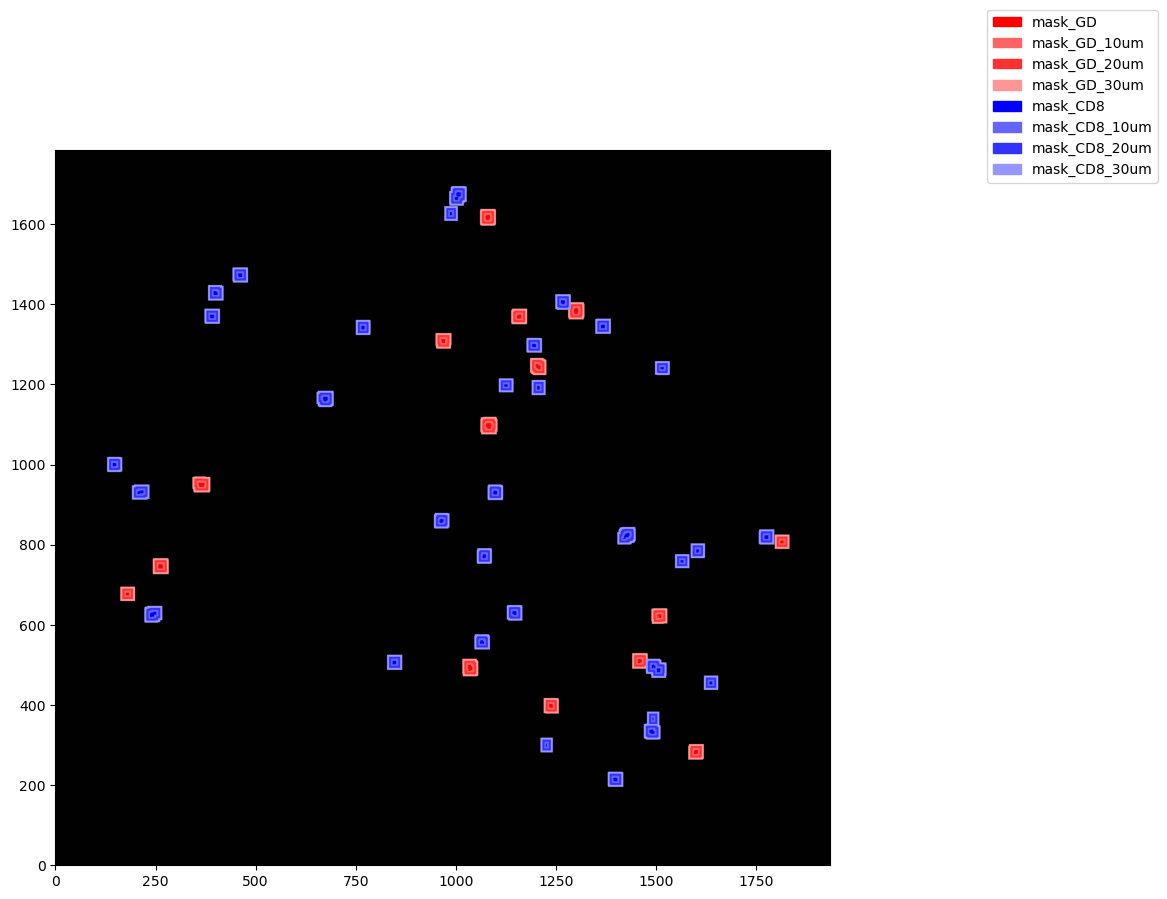

In [7]:
# ### single object analysis GD
GM = masks.GetMasks(image_shape=(height, width))

SA = masks.SingleClassObjectAnalysis(GM, contours_object=CGD.contours)
SA.get_mask_objects(exclude_masks=None)  # Not excluding any tum or empty 

SA.get_objects_expansion(expansions_pixels=[10, 20, 30],
                         exclude_masks=None)  # exclude from empty? or from tumour? Not excluding

mask_GD_10um, mask_GD_20um, mask_GD_30um = SA.masks_object_expansions
mask_GD = SA.mask_object_SA

SA = masks.SingleClassObjectAnalysis(GM, contours_object=CCD8.contours)
SA.get_mask_objects(exclude_masks=None)  # Not excluding any tum or empty 

SA.get_objects_expansion(expansions_pixels=[10, 20, 30],
                         exclude_masks=None)  # exclude from empty? or from tumour? Not excluding

mask_CD8_10um, mask_CD8_20um, mask_CD8_30um = SA.masks_object_expansions
mask_CD8 = SA.mask_object_SA



# Define the masks, their names and colors 
masks_plot = [mask_GD, mask_GD_10um, mask_GD_20um, mask_GD_30um, 
              mask_CD8, mask_CD8_10um, mask_CD8_20um, mask_CD8_30um]
mask_names = ['mask_GD','mask_GD_10um', 'mask_GD_20um', 'mask_GD_30um',
             'mask_CD8','mask_CD8_10um', 'mask_CD8_20um', 'mask_CD8_30um']
mask_colors = {
'mask_GD': (255, 0, 0),          # red
'mask_GD_10um': (255, 100, 100), # light red
'mask_GD_20um': (255, 50, 50),   # medium red
'mask_GD_30um': (255, 150, 150), # dark red

'mask_CD8': (0, 0, 255),         # blue
'mask_CD8_10um': (100, 100, 255),# light blue
'mask_CD8_20um': (50, 50, 255),  # medium blue
'mask_CD8_30um': (150, 150, 255) # dark blue  
}


GM.plot_masks(masks=masks_plot,
              mask_names=mask_names,
              background_color=(1, 1, 1),
              mask_colors=mask_colors, path=None, show=True, ax=None)
plt.show()  

To prevent overlap between the expansions of objects of different categories, one can run the multiclass object analysis. 


INFO:GRIDGEN.src.masks:Tumour mask not defined.
INFO:GRIDGEN.src.masks:Stroma mask not defined.


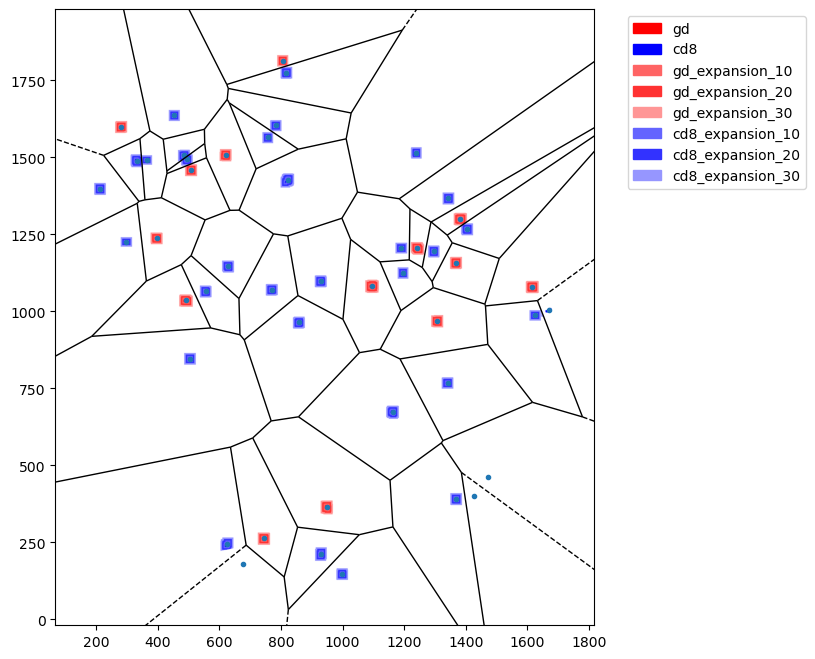

In [8]:
%autoreload
from GRIDGEN.src import masks
from GRIDGEN.src.masks import MultiClassObjectAnalysis

# ### single object analysis GD
GM = masks.GetMasks(image_shape=(height, width))



multiple_contours = {'gd': CGD.contours,
                    'cd8': CCD8.contours}

MCA = MultiClassObjectAnalysis(GM, multiple_contours,
                                # mask_T= mask_tumour_overall,mask_S =mask_stroma_overall,
                                )    # save path 

MCA.derive_voronoi_from_contours_approximate()
masks = MCA.generate_expanded_masks_limited_by_voronoi(expansion_distances=(10,20,30))

mask_colors = {
'gd': (255, 0, 0),          # red
'gd_expansion_10': (255, 100, 100), # light red
'gd_expansion_20': (255, 50, 50),   # medium red
'gd_expansion_30': (255, 150, 150), # dark red

'cd8': (0, 0, 255),         # blue
'cd8_expansion_10': (100, 100, 255),# light blue
'cd8_expansion_20': (50, 50, 255),  # medium blue
'cd8_expansion_30': (150, 150, 255) # dark blue  
}


MCA.plot_contours_expansion_with_voronoi_edges(mask_colors, show=True)


In [9]:
# save masks npy 

You can also, as in single object analysis, define Tumour and Stroma areas 

==== tumour ====
total contours found  141
total contours after filtering by area 29
====
total contours found  163
total contours after filtering by area 52


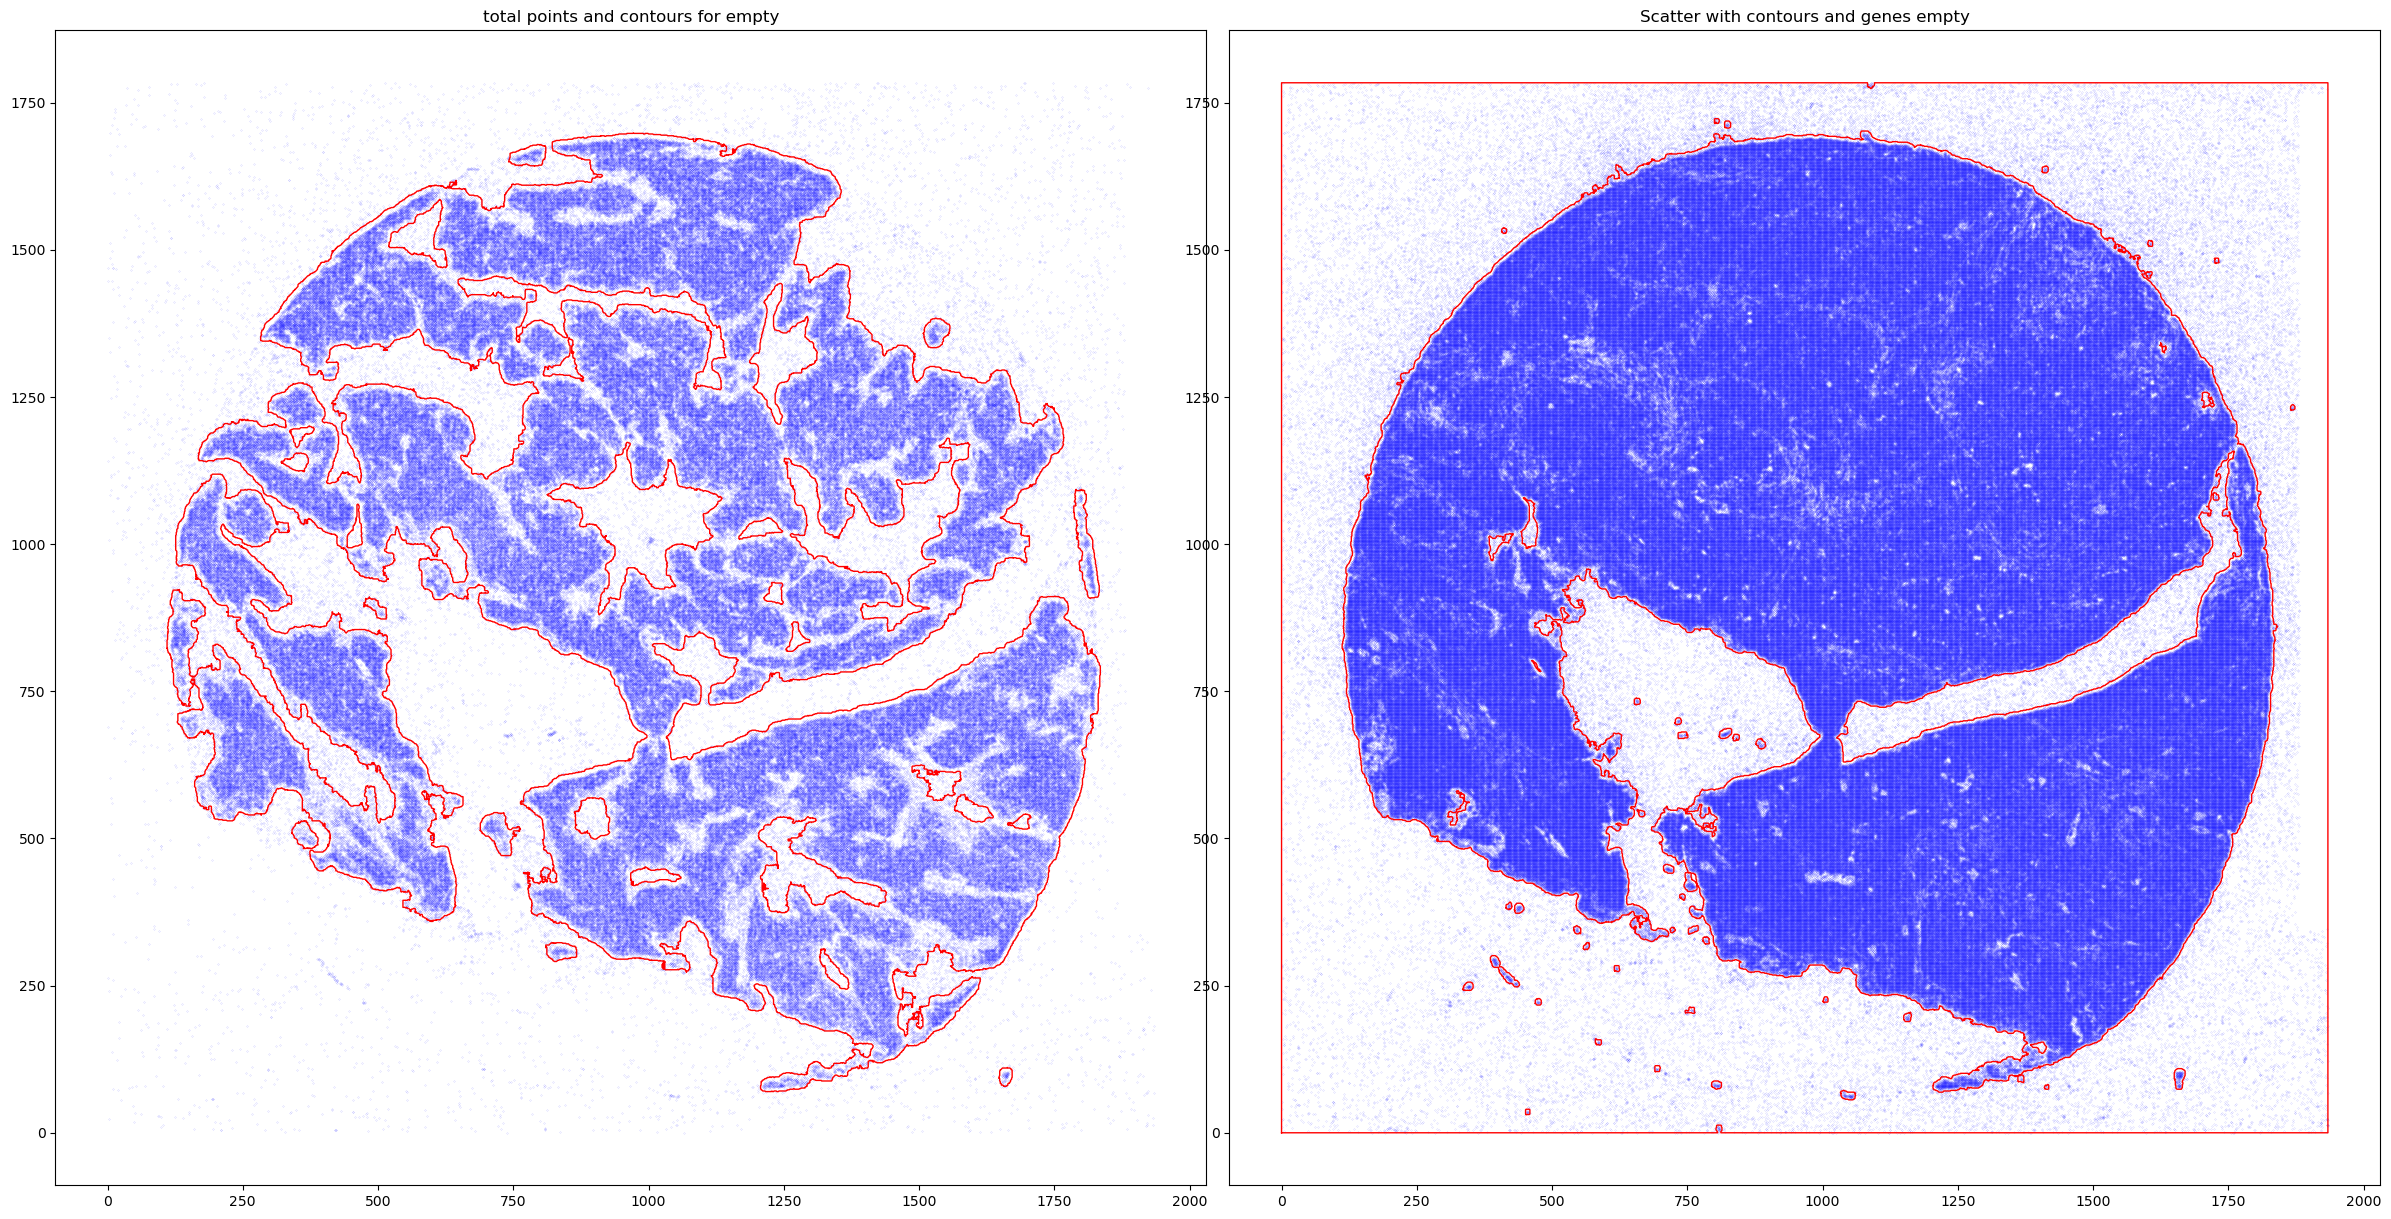

In [10]:
# defined with the gene list 
target_tum = ['EPCAM', 'SMIM22','CLDN3', 'KRT18','LGALS4', 'KRT8', 'ELF3','TSPAN8', 'STMN1', 'CD47', 'MYC', 'LGALS3'] 

# param tum
density_th_tum = 25    # 50
min_area_th_tum =  500 #1000    
kernel_size_tum = 20   # 20

# param empty
density_th_empty = 20
min_area_th_empty = 50 #400
kernel_size_empty = 10


# define the tumour array ( the one missing) 
df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                         target_list=target_tum, target_col = 'target')

# obtain contours 
CTum = contours.GetContour(array_subset_tum, contour_name='tum')
CTum.get_conv_sum(kernel_size=kernel_size_tum, kernel_shape='square')
CTum.contours_from_sum(density_threshold = density_th_tum,
                       min_area_threshold = min_area_th_tum , directionality = 'higher')

CEmpty = contours.GetContour(array_total, contour_name='empty')
CEmpty.get_conv_sum(kernel_size=kernel_size_empty, kernel_shape='square')
CEmpty.contours_from_sum(density_threshold = density_th_empty,
                       min_area_threshold = min_area_th_empty, directionality = 'lower') # attention that directionality is lower here 

print('==== tumour ====')
print('total contours found ', CTum.total_valid_contours)
print('total contours after filtering by area', CTum.contours_filtered_area)

print('====')
print('total contours found ', CEmpty.total_valid_contours)
print('total contours after filtering by area', CEmpty.contours_filtered_area)

# PLOTs -- instead of plotting just with the function for example: CTum.plot_contours_scatter, we will make a composite image 

fig, axs = plt.subplots(1, 2, figsize=(30, 15))
CTum.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                           c_points= 'blue',c_contours= 'red', ax=axs[0])
axs[0].set_title('Tum points and tum contours')  


CEmpty.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                           c_points= 'blue',c_contours= 'red', ax=axs[1])
axs[0].set_title('total points and contours for empty')  
plt.subplots_adjust(wspace=0.02)  # Adjust to your preference

plt.show()

We will update the Tumour and Stroma masks in relation to the masks of MCA analysis

INFO:GRIDGEN.src.masks:Filtering stroma mask by area: 700
INFO:GRIDGEN.src.masks:Filtering mask by area: 700
INFO:GRIDGEN.src.masks:creating non overlaping tumour mask of single object analysis. 
INFO:GRIDGEN.src.masks:creating non overlaping stroma mask of single object analysis. 


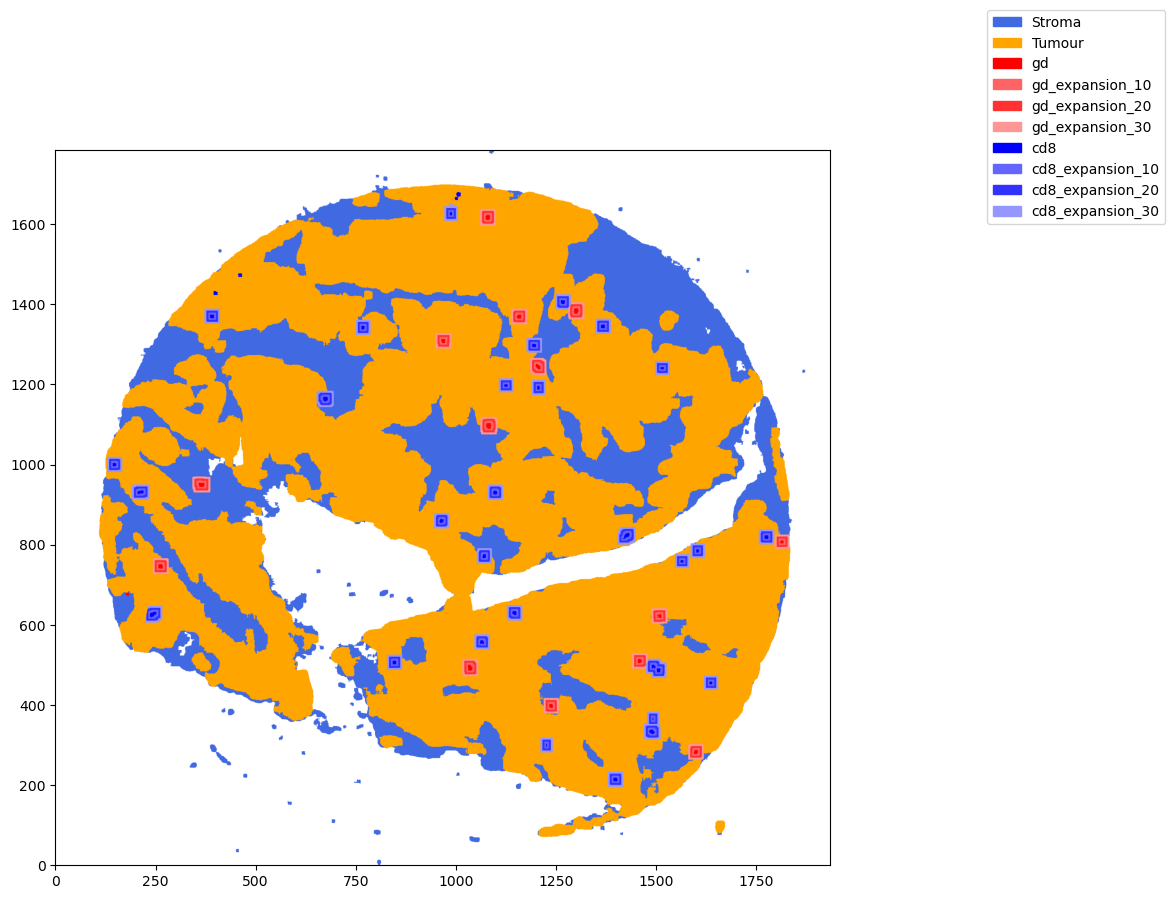

In [11]:
from GRIDGEN.src import masks

# tumour and Stroma masks 
GM = masks.GetMasks(image_shape=(height, width))

GM.get_masks_T_S_empty(contours_tum=CTum.contours, contours_empty=CEmpty.contours, filter_area=700)
# general masks
mask_stroma_overall = GM.mask_S
mask_tumour_overall = GM.mask_T

multiple_contours = {'gd': CGD.contours,
                    'cd8': CCD8.contours}

MCA = MultiClassObjectAnalysis(GM, multiple_contours,
                                # mask_T= mask_tumour_overall,mask_S =mask_stroma_overall,
                                )    # save path 

MCA.derive_voronoi_from_contours_approximate()
masks_MCA = MCA.generate_expanded_masks_limited_by_voronoi(expansion_distances=(10,20,30))

mask_stroma = MCA.mask_S  # it is without the GD and exansions area 
mask_tum = MCA.mask_T

# Define the masks and their names
masks_plot = [mask_stroma, mask_tum,
              masks_MCA['gd'], masks_MCA['gd_expansion_10'],masks_MCA['gd_expansion_20'], masks_MCA['gd_expansion_30'],
             masks_MCA['cd8'], masks_MCA['cd8_expansion_10'],masks_MCA['cd8_expansion_20'], masks_MCA['cd8_expansion_30']]

mask_names = ['Stroma', 'Tumour', 
              'gd', 'gd_expansion_10', 'gd_expansion_20', 'gd_expansion_30',
              'cd8', 'cd8_expansion_10', 'cd8_expansion_20', 'cd8_expansion_30']

mask_colors = {
    'Stroma': np.array([65, 105, 225]),  # Royal Blue
    'Tumour':  np.array([255, 165, 0]),  # Orange, 
    'gd': (255, 0, 0),          # red
    'gd_expansion_10': (255, 100, 100), # light red
    'gd_expansion_20': (255, 50, 50),   # medium red
    'gd_expansion_30': (255, 150, 150), # dark red
    
    'cd8': (0, 0, 255),         # blue
    'cd8_expansion_10': (100, 100, 255),# light blue
    'cd8_expansion_20': (50, 50, 255),  # medium blue
    'cd8_expansion_30': (150, 150, 255) # dark blue 
}

GM.plot_masks(masks=masks_plot,
              mask_names=mask_names,
              background_color=(255, 255, 255),
              mask_colors=mask_colors, path=None, show=True, ax=None)
plt.show()  

We can now extract information the same way that we did for Tumour/Stroma. 

We can do this either by agglomerating all the objects or do it by object.

We will consider each individual object of GD or CD8 as single.

This way we can also annotate how many pixels of the GD falls into regions identified indepedently as tumour and stroma. Because the tumour and stroma defined above are excluding the objects, we will use the base masks stroma and tumour. 

We can also derive the hierarchy of these objects, so the expansions of the GD are linked to which object they belong. 

In [12]:
masks_analysis_tb = [
    {'mask': mask_stroma, 'mask_name': 'Stroma', 'per_object': False, 'level_hierarchy': None, 'annotation': 1},
    {'mask': mask_tum, 'mask_name': 'Tumour', 'per_object': False, 'level_hierarchy':None,  'annotation': 1},
    
    {'mask': masks_MCA['gd'], 'mask_name': 'gd', 'per_object': True, 'level_hierarchy': 1,  'annotation': 2},
    {'mask': masks_MCA['gd_expansion_10'], 'mask_name': 'gd_expansion_10', 'per_object': True, 'level_hierarchy': 2, 'annotation': 2},
    {'mask': masks_MCA['gd_expansion_20'], 'mask_name': 'gd_expansion_20', 'per_object': True, 'level_hierarchy': 2, 'annotation': 2},
    {'mask': masks_MCA['gd_expansion_30'], 'mask_name': 'gd_expansion_30', 'per_object': True, 'level_hierarchy': 2, 'annotation': 2},

    {'mask': masks_MCA['cd8'], 'mask_name': 'cd8', 'per_object': True, 'level_hierarchy': 1,  'annotation': 2},
    {'mask': masks_MCA['cd8_expansion_10'], 'mask_name': 'cd8_expansion_10', 'per_object': True, 'level_hierarchy': 2, 'annotation': 2},
    {'mask': masks_MCA['cd8_expansion_20'], 'mask_name': 'cd8_expansion_20', 'per_object': True, 'level_hierarchy': 2, 'annotation': 2},
    {'mask': masks_MCA['cd8_expansion_30'], 'mask_name': 'cd8_expansion_30', 'per_object': True, 'level_hierarchy': 2, 'annotation': 2},
]

GP = GetMasksProperties(masks_dict = masks_analysis_tb,array_counts = array_total,
                        target_dict = target_dict_total,
                        logger = logger, image_shape = (height, width), save_path = None)

base_mask_dict =  [
        {'mask': mask_stroma_overall, 'mask_name': 'Stroma_overall'},
        {'mask': mask_tumour_overall, 'mask_name': 'Tumour_overall'},]

final_result = GP.get_mask_interest_annotations(base_mask_dict)
final_result = GP.get_gene_counts()

final_result

2024-11-08 19:52:21,391 - contour_logger - INFO - Running annotation analysis
INFO:contour_logger:Running annotation analysis
2024-11-08 19:52:21,391 - contour_logger - INFO - Label Mask Stroma_overall is empty. Labelling.
INFO:contour_logger:Label Mask Stroma_overall is empty. Labelling.
2024-11-08 19:52:22,307 - contour_logger - INFO - Label Mask Tumour_overall is empty. Labelling.
INFO:contour_logger:Label Mask Tumour_overall is empty. Labelling.
2024-11-08 19:52:23,256 - contour_logger - INFO - The annotation analysis took 1.87 seconds to execute
INFO:contour_logger:The annotation analysis took 1.87 seconds to execute
2024-11-08 19:57:11,919 - contour_logger - INFO - The run method took 288.66223978996277 seconds (4.811037329832713 minutes) to execute
INFO:contour_logger:The run method took 288.66223978996277 seconds (4.811037329832713 minutes) to execute


,mask_name,object_id,Stroma_overall_pixels,Stroma_overall_ids,Tumour_overall_pixels,Tumour_overall_ids,area,perimeter,centroid,min_x,...,SFTPD,IFNE,TRDV1,CCL13,IFNB1,VPREB3,CCL1,ELANE,IGHE,per_object
0,Stroma,0,NaN,NaN,NaN,NaN,434306.0,36843.107412,"(970.66540872104, 1025.51509534752)",0,...,5,28,6,21,5,1,10,10,2,False
1,Tumour,0,NaN,NaN,NaN,NaN,1362559.0,38360.283856,"(1024.6642075682594, 930.7888898755944)",70,...,31,61,7,51,18,3,24,9,3,False
2,cd8,1,0,[],71,[1],71.0,29.656854,"(147.83098591549296, 999.0)",995,...,0,0,0,0,0,0,0,0,0,True
3,cd8_expansion_10,1,0,[],243,[1],243.0,100.970563,"(148.53497942386832, 999.6460905349794)",991,...,0,0,0,0,0,0,0,0,0,True
4,cd8_expansion_20,1,0,[],460,[1],460.0,176.970563,"(148.43478260869566, 999.5)",986,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,cd8_expansion_30,29,0,[],647,[2],647.0,259.79899,"(1775.4064914992273, 819.0231839258114)",800,...,0,0,0,0,0,0,0,0,0,True
175,cd8,30,0,[],42,[2],42.0,22.0,"(1565.0, 757.5)",755,...,0,0,0,0,0,0,0,0,0,True
176,cd8,31,0,[],54,[2],54.0,25.414214,"(1603.888888888889, 783.6111111111111)",780,...,0,0,0,0,0,0,0,0,0,True
177,cd8,32,0,[],49,[2],49.0,24.0,"(1637.0, 454.0)",451,...,0,0,0,0,0,0,0,0,0,True


You can use this information to check how different the borders of Cd8 and GD are.